### Problem description:

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an 
iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 
passengers and crew. Women, children and the upper class were prioritized to board the lifeboats.

The dataset from https://www.kaggle.com/hesh97/titanicdataset-traincsv?select=train.csv contains information about 891 
people who were on board the ship. While there was some element of luck involved in surviving, it seems some groups of 
people were more likely to survive than the others. Using the information about 891 passengers, we are going to build a model
to predict which people would survive based on the following features:

1. PassengerId(int) - Passenger Id
2. Survived(int) - value 1 = Survived and value 0 = Did not survive
3. Pclass(int) - Ticket class
4. Name(str) - Name of the passenger
5. Sex(str) - Sex of the passenger
6. Age(float) - Age of the passenger
7. SibSp(int) - Number of siblings and spouses aboard
8. Parch(int) - Number of parents and children aboard
9. Ticket(str) - Ticket number
10. Fare(float) - Passenger fare
11. Cabin(str) - Cabin number
12. Embarked(str) - Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)


**We are first going to read our data and then do some exploratory data analysis.**



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)


titanic = pd.read_csv('titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**We can see here that name and ticket number are not going to be helpful in determining survival.\
Therefore, dropping 'Name' and 'Ticket' features.**

In [3]:
cat_drop = ['Name','Ticket'] 

titanic.drop(cat_drop, axis = 1, inplace = True)
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S


**We would like to see some basic statistical details of our dataset now.**

In [4]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**We can see here that percentage of people survived is 38.38% .**

**Now we will study the average of features with numeric values grouped by people who survived and those who did not.**

In [5]:
titanic.groupby('Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


**Difference in the average values of SibSp, Parch and Fare stand out.\
Fare stands out the most. Average fare for those who died is 22.11 and for those who survived is 48.39.**

**First we will check for the impact of Age feature on survival.\
We are going to group data by 'Age' feature. Age = True implies age was not recorded and has null value.**

In [6]:
titanic.groupby(titanic['Age'].isnull()).mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Age,,,,,,,
False,448.582633,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
True,435.581921,0.293785,2.598870,NaN,0.564972,0.180791,22.158567


**Here we see that age was recorded for high fare tickets but probably not for lower fare.\
Age is recorded for 40.61% of survivors and was not recorded for 29.37% of survivors.\
Age has some missing values which might be just at random.**

**We will now plot histogram to study impact on survival of 'Age' and 'Fare' features respectively.\
No. of people survived on y axis, age or fare on x axis respectively.**

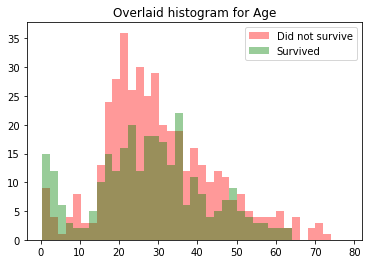

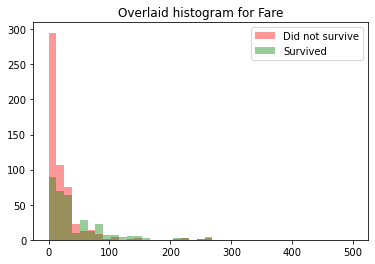

In [7]:
for i in ['Age','Fare']:
    died = list(titanic[titanic['Survived'] == 0][i].dropna())
    survived = list(titanic[titanic['Survived'] == 1][i].dropna())
    xmin = min(min(died),min(survived))
    xmax = max(max(died),max(survived))
    width = (xmax-xmin)/40
    sns.distplot(died,color='r', kde = False, bins = np.arange(xmin,xmax,width))
    sns.distplot(survived,color='g', kde = False, bins = np.arange(xmin,xmax,width))
    plt.legend(['Did not survive','Survived'])
    plt.title('Overlaid histogram for {}'.format(i))
    plt.show()

**From the plots above, we see that age doesn't really matter in survival but fare does.\
Higher the fare, more the chance of survival.**

**We will now replace null values in 'Age' with the mean age, because the model will work better for non null values.**

In [8]:
titanic['Age'].fillna(titanic['Age'].mean(), inplace = True)
titanic.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.000000,1,0,7.2500,NaN,S
1,2,1,1,female,38.000000,1,0,71.2833,C85,C
2,3,1,3,female,26.000000,0,0,7.9250,NaN,S
3,4,1,1,female,35.000000,1,0,53.1000,C123,S
4,5,0,3,male,35.000000,0,0,8.0500,NaN,S
5,6,0,3,male,29.699118,0,0,8.4583,NaN,Q
6,7,0,1,male,54.000000,0,0,51.8625,E46,S
7,8,0,3,male,2.000000,3,1,21.0750,NaN,S
8,9,1,3,female,27.000000,0,2,11.1333,NaN,S
9,10,1,2,female,14.000000,1,0,30.0708,NaN,C


**We will now study the following features: 'Pclass', 'SibSp' and 'Parch**


**Plotting categorical plot for impact on survival of each of these features.**

<Figure size 432x288 with 0 Axes>

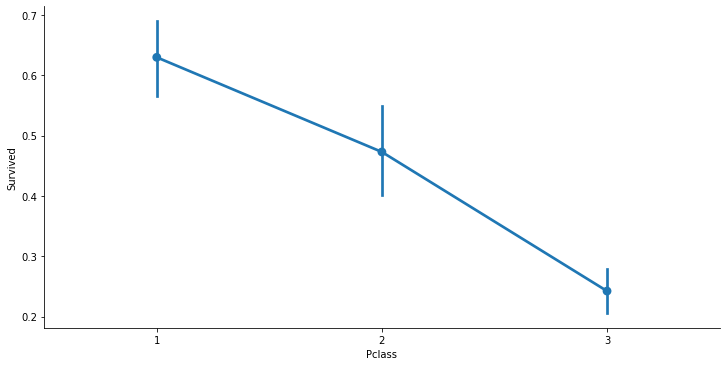

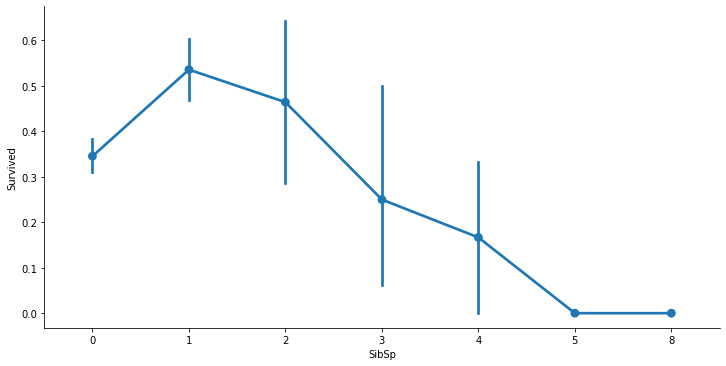

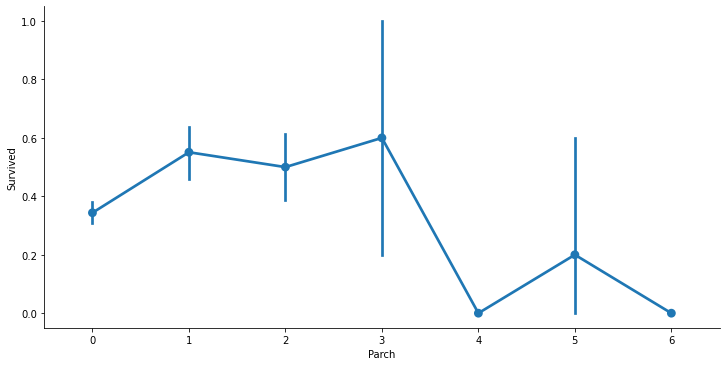

In [9]:
for i,col in enumerate(['Pclass','SibSp','Parch']):
    plt.figure(i)
    sns.catplot(x=col, y='Survived', data=titanic, kind='point', aspect=2,)

**From the plots, we can see that:\
Around 63% people from 1st class survived. Those in lower class were less likely to survive.\
Those with more siblings, parents or children are less likely to survive.**

**SibSp and Parch features can be merged into a new 'family-cnt' (family count) feature because they both represent family members.\
They have the same trend in impacting the survival and we can see that higher value of both implies lesser chance of survival.\
SibSp and Parch can be dropped now as they are repetitive**

In [10]:
titanic['family-count'] = titanic['SibSp'] + titanic['Parch']
titanic.drop(['SibSp','Parch'], axis=1, inplace=True)
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,family-count
0,1,0,3,male,22.0,7.2500,NaN,S,1
1,2,1,1,female,38.0,71.2833,C85,C,1
2,3,1,3,female,26.0,7.9250,NaN,S,0
3,4,1,1,female,35.0,53.1000,C123,S,1
4,5,0,3,male,35.0,8.0500,NaN,S,0


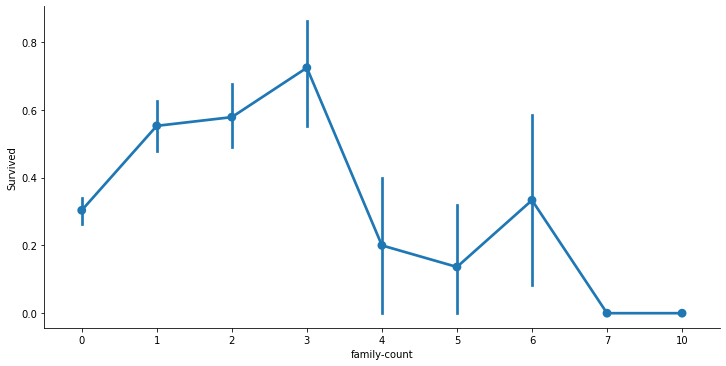

In [11]:
sns.catplot(x='family-count', y='Survived', data=titanic, kind='point', aspect=2,)

**We can see from the above plot that the same pattern persists in family-count as in SibPb and Parch features.\
Higher the family count, lower the chance of survival.**

**Exploring categorical features now.**

In [12]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Sex           891 non-null    object 
 4   Age           891 non-null    float64
 5   Fare          891 non-null    float64
 6   Cabin         204 non-null    object 
 7   Embarked      889 non-null    object 
 8   family-count  891 non-null    int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


**The above information shows that there are lots of values missing for 'Cabin' feature (only 204 non-null values) and a few missing values for 'Embarked' feature**

In [13]:
titanic.groupby(titanic['Cabin'].isnull()).mean()

,PassengerId,Survived,Pclass,Age,Fare,family-count
Cabin,,,,,,
False,455.401961,0.666667,1.196078,35.258349,76.141504,0.877451
True,443.208151,0.299854,2.639010,28.048341,19.157325,0.912664


**Cabin = True implies cabin value is missing.\
66.66% people who survived had cabins. So, it is a very strong indicator for whether somebody survived or not**

**Adding a binary cabin indicator ('cabin_ind') feature to indicate if a person had a cabin (1) or not (0).\
Dropping 'Cabin' feature as it is no longer required.**

In [14]:
titanic['cabin_ind'] = np.where(titanic['Cabin'].isnull(),0,1)
titanic.drop(['Cabin'], axis=1, inplace=True)
titanic.head(12)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,family-count,cabin_ind
0,1,0,3,male,22.000000,7.2500,S,1,0
1,2,1,1,female,38.000000,71.2833,C,1,1
2,3,1,3,female,26.000000,7.9250,S,0,0
3,4,1,1,female,35.000000,53.1000,S,1,1
4,5,0,3,male,35.000000,8.0500,S,0,0
5,6,0,3,male,29.699118,8.4583,Q,0,0
6,7,0,1,male,54.000000,51.8625,S,0,1
7,8,0,3,male,2.000000,21.0750,S,4,0
8,9,1,3,female,27.000000,11.1333,S,2,0
9,10,1,2,female,14.000000,30.0708,C,1,0


**We will now plot categorical features 'cabin_ind', 'Sex' and 'Embarked'.**

<Figure size 432x288 with 0 Axes>

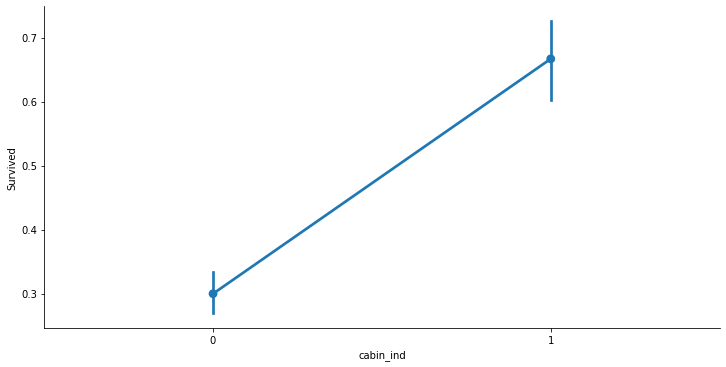

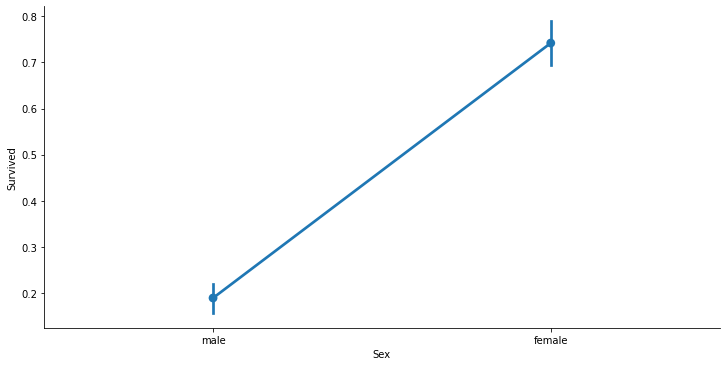

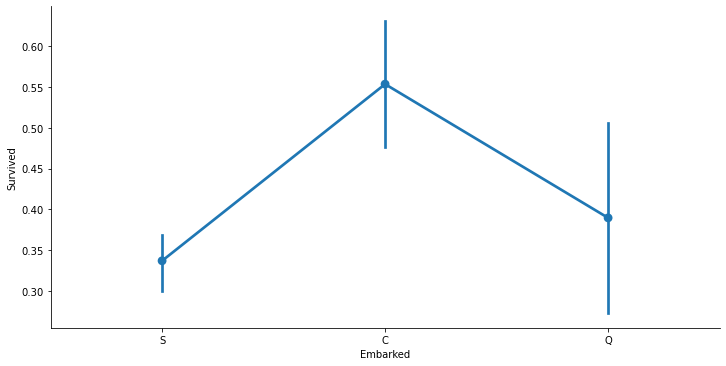

In [15]:
for i,col in enumerate(['cabin_ind','Sex','Embarked']):
    plt.figure(i)
    sns.catplot(x=col,y='Survived',data=titanic,kind='point',aspect=2,)

**We can deduce the following from the above plots:\
More than 65% survivors had cabins.\
More than 70% survivors were females.**

**Therefore, cabin_id and sex are strong indicators of survival.\
It's unlikely that place of embarking decides survival chance. And we can see that Embarked is not a very strong indicator for survival so we can remove it.**

In [16]:
titanic.drop(['Embarked'], axis=1, inplace=True)
titanic.head(10)

,PassengerId,Survived,Pclass,Sex,Age,Fare,family-count,cabin_ind
0,1,0,3,male,22.000000,7.2500,1,0
1,2,1,1,female,38.000000,71.2833,1,1
2,3,1,3,female,26.000000,7.9250,0,0
3,4,1,1,female,35.000000,53.1000,1,1
4,5,0,3,male,35.000000,8.0500,0,0
5,6,0,3,male,29.699118,8.4583,0,0
6,7,0,1,male,54.000000,51.8625,0,1
7,8,0,3,male,2.000000,21.0750,4,0
8,9,1,3,female,27.000000,11.1333,2,0
9,10,1,2,female,14.000000,30.0708,1,0


**Converting 'Sex' feature to binary (1 for female and 0 for male) as the model works better on numeric inputs.**

In [17]:
gender_num = {'male':0, 'female':1}
titanic['Sex'] = titanic['Sex'].map(gender_num)
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,family-count,cabin_ind
0,1,0,3,0,22.0,7.2500,1,0
1,2,1,1,1,38.0,71.2833,1,1
2,3,1,3,1,26.0,7.9250,0,0
3,4,1,1,1,35.0,53.1000,1,1
4,5,0,3,0,35.0,8.0500,0,0


**Writing a new file with clean data**

In [18]:
titanic.to_csv('titanic_cleaned.csv',index=False)

**Splitting data into train, test and validation datasets**

In [19]:
titanic = pd.read_csv('titanic_cleaned.csv')
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,family-count,cabin_ind
0,1,0,3,0,22.0,7.2500,1,0
1,2,1,1,1,38.0,71.2833,1,1
2,3,1,3,1,26.0,7.9250,0,0
3,4,1,1,1,35.0,53.1000,1,1
4,5,0,3,0,35.0,8.0500,0,0


In [26]:
features = titanic.drop('Survived', axis=1)
labels = titanic[['Survived']]

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.4, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

In [27]:
x_test.head()

,PassengerId,Pclass,Sex,Age,Fare,family-count,cabin_ind
849,850,1,1,29.699118,89.1042,1,1
331,332,1,0,45.500000,28.5000,0,1
260,261,3,0,29.699118,7.7500,0,0
316,317,2,1,24.000000,26.0000,1,0
292,293,2,0,36.000000,12.8750,0,1


**Checking for percentage data in the split datasets.\
There should be 60% in train dataset, 20% in test dataset and 20% in validation dataset.**

In [28]:
for dataset in [y_train, y_test, y_val]:
    print(round(len(dataset)/len(labels),2))

0.6
0.2
0.2


**Writing train, test and validation datasets in seperate files.**

In [29]:
x_train.to_csv('train_features.csv', index=False)
x_test.to_csv('test_features.csv', index=False)
x_val.to_csv('val_features.csv', index=False)

y_train.to_csv('train_labels.csv', index=False)
y_test.to_csv('test_labels.csv', index=False)
y_val.to_csv('val_labels.csv', index=False)

**Now we will perform cross validation 5 times on our train dataset.**

In [30]:
tr_features = pd.read_csv('train_features.csv')
tr_labels = pd.read_csv('train_labels.csv')

In [35]:
rf = RandomForestClassifier()
scores = cross_val_score(rf, tr_features, tr_labels.values.ravel(), cv=5)
print('Cross validation scores: ' , scores)
print('Mean of Cross validation scores:', scores.mean())


Cross validation scores:  [0.85046729 0.8317757  0.76635514 0.77570093 0.85849057]
Mean of Cross validation scores: 0.8165579262916592


**We can see the mean of Cross validation scores above**

**We will now do hyperparameter tuning to find the best model.**

In [36]:
def print_results(results):
    print('Best Parameters: {}\n'.format(results.best_params_))
    
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std*2, 3), params))

In [39]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators' : [5, 50, 100],
    'max_depth' : [2, 10, 20, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

Best Parameters: {'max_depth': 10, 'n_estimators': 100}

0.766 (+/-0.148) for {'max_depth': 2, 'n_estimators': 5}
0.807 (+/-0.092) for {'max_depth': 2, 'n_estimators': 50}
0.798 (+/-0.122) for {'max_depth': 2, 'n_estimators': 100}
0.809 (+/-0.053) for {'max_depth': 10, 'n_estimators': 5}
0.817 (+/-0.098) for {'max_depth': 10, 'n_estimators': 50}
0.822 (+/-0.083) for {'max_depth': 10, 'n_estimators': 100}
0.788 (+/-0.076) for {'max_depth': 20, 'n_estimators': 5}
0.818 (+/-0.074) for {'max_depth': 20, 'n_estimators': 50}
0.803 (+/-0.081) for {'max_depth': 20, 'n_estimators': 100}
0.794 (+/-0.099) for {'max_depth': None, 'n_estimators': 5}
0.811 (+/-0.08) for {'max_depth': None, 'n_estimators': 50}
0.809 (+/-0.076) for {'max_depth': None, 'n_estimators': 100}


**We can see that the best model has parameters: max_depth = 10 , no. of estimators  = 100.**

**We will evaluate the three best models on validation and test datasets.**

In [79]:
tr_features = pd.read_csv('train_features.csv')
tr_labels = pd.read_csv('train_labels.csv')

val_features = pd.read_csv('val_features.csv')
val_labels = pd.read_csv('val_labels.csv')

test_features = pd.read_csv('test_features.csv')
test_labels = pd.read_csv('test_labels.csv')

In [80]:
#best parameters from earlier
rf1 = RandomForestClassifier(n_estimators = 100 , max_depth = 10) 
rf1.fit(tr_features, tr_labels.values.ravel())

# next two best models
rf2 = RandomForestClassifier(n_estimators = 50 , max_depth = 20) 
rf2.fit(tr_features, tr_labels.values.ravel())

rf3 = RandomForestClassifier(n_estimators = 50 , max_depth = 10) 
rf3.fit(tr_features, tr_labels.values.ravel())

RandomForestClassifier(max_depth=10, n_estimators=50)

**We have run our three best models on train data. Now, we will make predictions using these three models on validation dataset and check for accuracy(A), precision(P) and recall(R) scores for all three models.**

In [81]:
for model in [rf1, rf2, rf3]:
    y_pred = model.predict(val_features) #predictions
    accuracy = round(accuracy_score(val_labels, y_pred) , 3)
    precision = round(precision_score(val_labels, y_pred) , 3)
    recall = round(recall_score(val_labels, y_pred) , 3)
    print('Max Depth:{} / No. of Est:{} -- A:{} / P:{} / R:{}'.format(model.max_depth, model.n_estimators, accuracy, precision, recall))
    

Max Depth:10 / No. of Est:100 -- A:0.827 / P:0.869 / R:0.697
Max Depth:20 / No. of Est:50 -- A:0.804 / P:0.836 / R:0.671
Max Depth:10 / No. of Est:50 -- A:0.827 / P:0.881 / R:0.684


**Model 1 with max depth 10 and no. of estimators 100 seems best.**

**Finally, We will make predictions using the first model on test dataset and check for accuracy, precision and recall scores**

In [82]:
y_pred = rf1.predict(test_features)
accuracy = round(accuracy_score(test_labels, y_pred , 3))
precision = round(precision_score(test_labels, y_pred , 3))
recall = round(recall_score(test_labels, y_pred , 3))
print('Max Depth:{} / No. of Est:{} -- A:{} / P:{} / R:{}'.format(rf1.max_depth, rf1.n_estimators, accuracy, precision, recall))

Max Depth:10 / No. of Est:100 -- A:1 / P:1 / R:1


**Accuracy, Precision and recall all equal to 1. The first model with max depth 10 and no. of estimators 100 is the best model for predicting the survival of a person on Titanic.**